## Alpaca Automated Stock Trading

> Moving strategy from R to the native python API client

### Strategy Parameters
1. N_DAYS_AGO
    - How many days of historical data to pull each run
2. OLS_Window
    - Rolling window for alpha / beta (intercept / slope) linear fit to general market movement

In [21]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

In [22]:
N_DAYS_AGO = 365
OLS_Window = 5
min_list_years = 5
min_volume = 400000
max_investment = 1180*0.2
min_investment = 15

In [75]:
%matplotlib inline
## Installing Required Packages
import sys
import time
import math
import pickle
import alpaca_trade_api as tradeapi
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy import stats

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Pulling API Keys
Keys = pd.read_csv(os.path.join('..','Data','Keys','Live API.txt'))

## Connecting to Alpaca
api = tradeapi.REST(Keys['Key ID'][0],Keys['Secret Key'][0], api_version='v2')

## API Initial Set Up
### Get Current Account Information
account = api.get_account()

## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


### Historical Data Pull

In [24]:
## Pulling All Available Alpaca Symbols
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets \
                if i._raw['tradable'] \
                    & i._raw['shortable'] \
                    & i._raw['easy_to_borrow']]

## Pulling All Bar Data
s_inc = 100
print("Starting Initial Data Pull")
Splits = [0]
while Splits[len(Splits)-1] < (len(Final_Assets)-1):
    if Splits[len(Splits)-1] + s_inc > (len(Final_Assets)-1):
        Splits.append((len(Final_Assets)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + s_inc)
Initial_Bars = {}
for i in tqdm(range(1,len(Splits))):
    Initial_Bars.update(api.get_barset(symbols = Final_Assets[Splits[i-1]:Splits[i]],
                                      timeframe = 'day',
                                      limit = N_DAYS_AGO))

print("Filtering Based On Average Price and Volume")
## Filtering Based On Price And Volume Criteria
Stocks = []
for i in tqdm(Final_Assets):
    try:
        Price_Data = Initial_Bars[i].df
        Price = np.mean(Price_Data['close'])
        Volume = np.mean(Price_Data['volume'])
        if Price < max_investment \
        and Price > min_investment \
        and i in Final_Assets \
        and Volume > min_volume:
            Stocks.append(i)
    except:
        print("Skipped",i,"No Data")

print("Pulling Company Data")
## Pulling Polygon Company Data
Splits = [0]
while Splits[len(Splits)-1] < (len(Stocks)-1):
    if Splits[len(Splits)-1] + 50 > (len(Stocks)-1):
        Splits.append((len(Stocks)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + 50)
Company_Data = {}
for i in tqdm(range(1,len(Splits))):
    Company_Data.update(api.polygon.company(Stocks[Splits[i-1]:Splits[i]]))

## Filtering Based on Company Information
Updated_Stocks = list(Company_Data.keys())
Final_Stocks = []
for i in Updated_Stocks:
    if not Company_Data[i].active:
        continue
    if years_listed(Company_Data[i].listdate) > min_list_years:
        Final_Stocks.append(i)
        
## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

print("Formatting Final Dataset")
## Formatting Final Dataset
counter = 0
for i in tqdm(Final_Stocks):
    TMP = Initial_Bars[i].df
    TMP['date'] = TMP.index
    TMP['sector'] = Company_Data[i].sector
    TMP['industry'] = Company_Data[i].industry
    Historical_Data[i] = TMP 

## Adding Ticker Column
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]

## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

Starting Initial Data Pull



Filtering Based On Average Price and Volume


Skipped BHP No Data

Pulling Company Data



Formatting Final Dataset


### Exploring Total Market Performance

In [26]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
Combined_Data = Combined_Data.drop_duplicates()
Combined_Data = Combined_Data[(datetime.now() - timedelta(days = N_DAYS_AGO)).strftime("%Y-%m-%d"):datetime.now().strftime("%Y-%m-%d")]

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]
Total_Market.tail(10)

,close,high,low,volume,count,close_diff,close_return,volume_diff,sma,RSI,MACD
date,,,,,,,,,,,
2020-09-29 00:00:00-04:00,65.195459,66.196922,64.530452,2.812469e+06,1084.0,-0.004953,0.006236,0.634527,64.379520,40.605377,-0.087885
2020-09-30 00:00:00-04:00,65.574222,66.641249,64.752837,3.285394e+06,1084.0,0.005810,0.033996,0.168153,64.810712,40.962567,-0.013398
2020-10-01 00:00:00-04:00,66.171619,67.022268,65.113151,3.242815e+06,1084.0,0.009110,0.043198,-0.012960,65.358738,40.229825,0.074465
2020-10-02 00:00:00-04:00,66.273693,67.123290,64.574454,3.012500e+06,1084.0,0.001543,0.030176,-0.071023,65.746992,42.825847,0.134327
2020-10-05 00:00:00-04:00,67.594088,68.085900,66.284860,2.817823e+06,1084.0,0.019923,0.031656,-0.064623,66.161816,36.960331,0.250945
2020-10-06 00:00:00-04:00,67.085371,68.898977,66.606159,3.246684e+06,1084.0,-0.007526,0.028988,0.152196,66.539799,42.738618,0.279721
2020-10-07 00:00:00-04:00,68.365402,69.052054,67.275742,2.841361e+06,1084.0,0.019081,0.042565,-0.124842,67.098035,46.000508,0.365447
2020-10-08 00:00:00-04:00,69.079082,69.748276,68.040867,2.987563e+06,1084.0,0.010439,0.043938,0.051455,67.679527,46.441937,0.445398
2020-10-09 00:00:00-04:00,69.538551,70.418699,68.729520,2.842848e+06,1083.0,0.006651,0.049263,-0.048439,68.332499,44.564374,0.500300


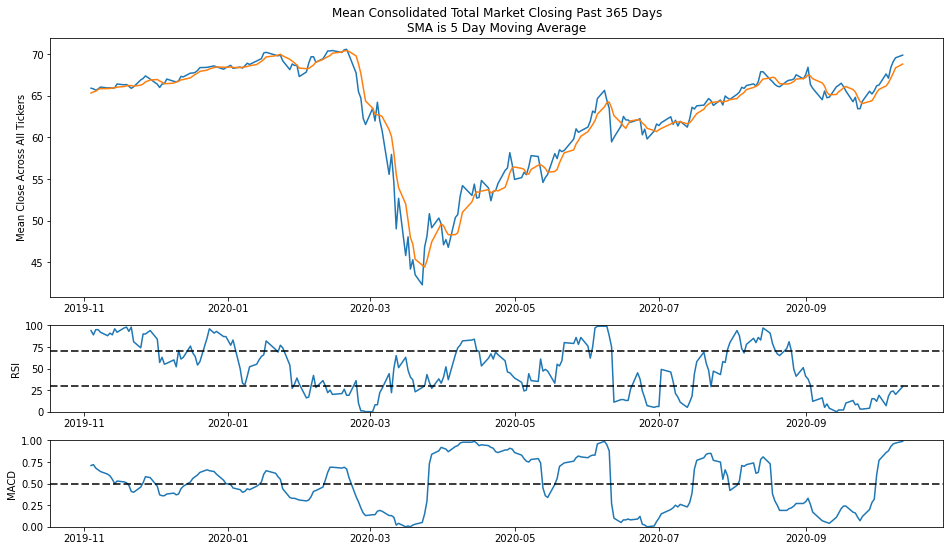

In [82]:
Plot_Data = Total_Market
Plot_Data['RSI'] = pd.qcut(Plot_Data.RSI,100,labels = False)
# Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100
Plot_Data['MACD'] = pd.qcut(Plot_Data.MACD,100,labels = False)/100
# Plot_Data['MACD'] = (1 + 1)*((Plot_Data['MACD'] -  np.min(Plot_Data['MACD'])) / (np.max(Plot_Data['MACD']) - np.min(Plot_Data['MACD']))) - 1

Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0.50,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(OLS_Window) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(
    ylabel = "MACD",
    xlabel = "",
    ylim = [0,1]
)
fig.set_size_inches(16,9)

In [78]:
pd.qcut(Total_Market.RSI,100,labels = False)

date
2019-11-04 00:00:00-05:00    94
2019-11-05 00:00:00-05:00    89
2019-11-06 00:00:00-05:00    95
2019-11-07 00:00:00-05:00    95
2019-11-08 00:00:00-05:00    92
                             ..
2020-10-06 00:00:00-04:00    18
2020-10-07 00:00:00-04:00    23
2020-10-08 00:00:00-04:00    24
2020-10-09 00:00:00-04:00    20
2020-10-12 00:00:00-04:00    29
Name: RSI, Length: 237, dtype: int64

In [86]:
## Calculating Market Deciders
Market_Strength = np.mean(Total_Market.RSI.tail(5))/100
Market_Momentum = (np.mean(Plot_Data.MACD.tail(5))-np.min(Plot_Data.MACD.tail(5)))/(np.max(Plot_Data['MACD'].tail(5)) - np.min(Plot_Data['MACD'].tail(5)))
print("Market Strength :",np.round(Market_Strength,3),
      "\nMarket_Momentum :",np.round(Market_Momentum,3))

Max_Beta_P = np.round(1 - Market_Momentum,3)
Min_Beta = 1 if Market_Momentum > 0.50 else -2
Max_Alpha_P = np.round(Market_Momentum,3)
Min_Alpha = 0 if Market_Momentum <= 0.50 else -1

print("Beta Significance :",Max_Beta_P,
     "\nAlpha Significance :",Max_Alpha_P)

Market Strength : 0.228 
Market_Momentum : 0.6
Beta Significance : 0.4 
Alpha Significance : 0.6


## Digging Into A Sector Ranking

In [84]:
Sectors = list(Combined_Data['sector'].unique())
Sector_Summary = Group_Consolidator(Combined_Data = Combined_Data,
                                    groups = Sectors,
                                    column = 'sector',
                                    min_macd = 0,
                                    max_beta_p = Max_Beta_P,
                                    max_alpha_p = Max_Alpha_P,
                                    min_beta = Min_Beta,
                                    min_alpha = Min_Alpha,
                                    max_rsi = 70,
                                    min_risk_ratio = 1
)
Sector_Summary

,stock_count,last_period_return,Entry,Exit,Loss,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
sector,,,,,,,,,,,,,,
Healthcare,148,0.040925,80.701541,87.222527,77.441049,82.600768,1.254915,0.005324,54.360169,0.527839,-0.002096,0.538,1.303553,0.0


## Diving Further Into Individual Idustries

In [87]:
Top_Sector = Combined_Data[Combined_Data['sector'].isin(Sector_Summary.index.values)]
Industries = list(Top_Sector['industry'].unique())
Industry_Summary = Group_Consolidator(Combined_Data = Top_Sector,
                                      groups = Industries,
                                      column = 'industry',
                                      min_macd = 0,
                                      max_beta_p = Max_Beta_P,
                                      max_alpha_p = Max_Alpha_P,
                                      min_beta = Min_Beta,
                                      min_alpha = Min_Alpha,
                                      max_rsi = 70,
                                      min_risk_ratio = 1
                                     )
Industry_Summary

,stock_count,last_period_return,Entry,Exit,Loss,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
industry,,,,,,,,,,,,,,
Medical Devices,17,0.041548,110.468057,121.831354,104.786409,113.452429,1.343409,0.004629,60.237088,0.554708,-0.003234,0.596,1.451923,0.016
Biotechnology,53,0.041522,70.485186,76.634425,67.410567,72.144685,1.180824,0.004548,44.251667,0.400563,-0.004658,0.582,1.667329,0.040
Medical Distribution,6,0.016942,68.621675,72.798325,66.533350,69.395333,1.322361,0.001649,47.212406,0.252129,-0.005493,0.514,1.138976,0.092


## Diving Into The Individual Stocks

In [90]:
Top_Industry = Top_Sector[Top_Sector['industry'].isin(Industry_Summary.index.values)]
Stocks = list(Top_Industry['stock'].unique())
Stock_Summary = Group_Consolidator(Combined_Data = Top_Industry,
                                   groups = Stocks,
                                   column = 'stock',
                                   min_macd = 0,
                                   min_risk_ratio = 1,
                                   max_rsi = 50
)
Stock_Summary. \
    sort_values(by = ['rsi'],ascending = [1])

,stock_count,last_period_return,Entry,Exit,Loss,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
stock,,,,,,,,,,,,,,
PEN,1,0.069703,197.732480,234.367520,179.414960,204.122,1.063657,0.002410,40.552269,1.371555,0.000788,0.530,1.624188,0.160
MCK,1,0.015918,148.551600,159.428400,143.113200,150.060,1.664273,0.000690,41.493001,0.252223,-0.007050,0.474,1.315286,0.102
KURA,1,0.071522,31.359020,35.820980,29.128040,32.754,1.897445,0.009323,41.860254,0.019989,-0.001519,0.906,1.979098,0.172
CAH,1,0.022823,47.067020,50.292980,45.454040,47.732,1.220332,0.002067,42.941395,0.289037,-0.004190,0.580,1.110545,0.114
ABC,1,0.006693,96.298460,100.661540,94.116920,96.682,2.003833,0.001270,46.657207,0.253377,-0.002806,0.646,0.532677,0.432
CARA,1,0.075414,13.537620,14.662380,12.975240,13.912,1.555736,-0.000490,46.870483,0.139375,0.001822,0.364,1.641027,0.052
QURE,1,0.014661,36.156240,39.023760,34.722480,37.186,1.379281,-0.005488,47.351163,0.009510,-0.011912,0.442,1.971125,0.262
EW,1,0.036530,80.636472,89.283528,76.312944,82.108,1.187431,0.005718,48.859573,0.271008,-0.005316,0.510,1.599769,0.024
BMRN,1,0.030911,76.772360,82.927640,73.694720,78.316,1.345382,0.000591,49.970192,1.125255,-0.007687,0.214,1.765409,0.002


In [91]:
Stocks = []
Stocks.extend(list(Stock_Summary.index))
Stocks = list(set(Stocks))

Stock_Data = pd.DataFrame()
for Stock in Stocks:
    Stock_Data[Stock] = Combined_Data['close'][Combined_Data.stock == Stock]
    
mu = expected_returns.mean_historical_return(Stock_Data)#returns.mean() * 252
S = risk_models.sample_cov(Stock_Data) #Get the sample covariance matrix


ef = EfficientFrontier(
    expected_returns = mu,
    cov_matrix = S, 
    weight_bounds = (0,0.20),
    verbose = False
)
weights = ef.max_sharpe() #Maximize the Sharpe ratio, and get the raw weights
cleaned_weights = ef.clean_weights() 

Final_Picks = []
for stock in cleaned_weights.keys():
    if cleaned_weights[stock] > 0:
        print(stock," : ",cleaned_weights[stock])
        Final_Picks.append(stock)
        
Optimized_Portfolio = ef.portfolio_performance(verbose=True)

ABC  :  0.2
PEN  :  0.2
KURA  :  0.2
BMRN  :  0.2
MCK  :  0.2
Expected annual return: 47.3%
Annual volatility: 38.3%
Sharpe Ratio: 1.18
